# Отток клиентов

На основании исторических данных оттока клиентов банка. Необходимо построить модель прогнозирования.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score,\
precision_score, recall_score, precision_recall_curve
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pd.options.display.float_format = '{:,.2f}'.format

SEED = 4444 # константа для random_state

# 1. Подготовка данных

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.00,0.00,2,1,0,"96,270.64",0
9996,9997,15569892,Johnstone,516,France,Male,35,10.00,"57,369.61",1,1,1,"101,699.77",0
9997,9998,15584532,Liu,709,France,Female,36,7.00,0.00,1,0,1,"42,085.58",1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.00,"75,075.31",2,1,0,"92,888.52",1


Первые три колонки не дадут нашей модели никакой полезной информации, избавимся от них

In [3]:
data = data.iloc[:,3:]
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.00,0.00,2,1,0,"96,270.64",0
9996,516,France,Male,35,10.00,"57,369.61",1,1,1,"101,699.77",0
9997,709,France,Female,36,7.00,0.00,1,0,1,"42,085.58",1
9998,772,Germany,Male,42,3.00,"75,075.31",2,1,0,"92,888.52",1


Имена колонок преобразуем в snake_case

In [4]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in data.columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
credit_score        10000 non-null int64
geography           10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
tenure              9091 non-null float64
balance             10000 non-null float64
num_of_products     10000 non-null int64
has_cr_card         10000 non-null int64
is_active_member    10000 non-null int64
estimated_salary    10000 non-null float64
exited              10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


В колонке с количеством недвижимости есть пропуски. Типы данных в таблице указаны верно

In [6]:
print('Пропущенных значений в признаке tenure: {:.2%}'.format(data['tenure'].isnull()
                                           .sum()/data['tenure'].shape[0]))

Пропущенных значений в признаке tenure: 9.09%


In [7]:
data[data['tenure'].isnull()]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,nan,0.00,3,1,0,"140,469.38",1
48,550,Germany,Male,38,nan,"103,391.38",1,0,1,"90,878.13",0
51,585,Germany,Male,36,nan,"146,050.97",2,0,0,"86,424.57",0
53,655,Germany,Male,41,nan,"125,561.97",1,0,0,"164,040.94",1
60,742,Germany,Male,35,nan,"136,857.00",1,0,0,"84,509.57",0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,nan,"190,409.34",2,1,1,"138,361.48",0
9956,520,France,Female,46,nan,"85,216.61",1,1,0,"117,369.52",1
9964,479,France,Male,34,nan,"117,593.48",2,0,0,"113,308.29",0
9985,659,France,Male,36,nan,"123,841.49",2,1,0,"96,833.00",0


Не вижу закономерности в пропусках, возможно у этих клиентов нет недвижимости, но не возьмусь утверждать. При работе с моделью попробую удалить или подставить нули.

In [8]:
#data = data.fillna(data['tenure'].median())
data = data.fillna(0)

Если заменить пропуски на нули, точность модели выше. Видимо пропуски действительно соответствуют клиентам без недвижимости.

In [9]:
data.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,650.53,38.92,4.54,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,96.65,10.49,3.11,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,652.00,37.00,4.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,718.00,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00
max,850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


Не вижу выбросов или подозрительных значений

In [10]:
data.duplicated().sum()

0

In [11]:
data['exited'].value_counts(normalize=True)

0   0.80
1   0.20
Name: exited, dtype: float64

Не сбалансированный целевой признак в выборке.

In [12]:
train, test = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['exited'])


Отделили тестовую выборку

In [13]:
train = pd.get_dummies(train, drop_first=True)
train.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'exited',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')

Перекодировали категориальные признаки с помощью OHE

In [14]:
target = train['exited']
features = train.drop(['exited'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features,
                                target, test_size=0.2, random_state=SEED, stratify=target)

Разбили на тренировочную и валидационную выборки 

In [15]:
numeric_column = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 
                 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric_column])

features_train[numeric_column] = scaler.transform(features_train[numeric_column])
features_valid[numeric_column] = scaler.transform(features_valid[numeric_column])

Масштабировали количественные признаки

# 2. Исследование задачи

In [16]:
model_score = pd.DataFrame(columns=['model_name', 'f1', 'auc_roc'])


def print_and_add(df, name, f1, auc_roc): # вывод показателей и запись их в таблицу
    print('best F1: {:.3f}'.format(f1))
    print('best AUC-ROC: {:.3f}'.format(auc_roc))
    return df.append({'model_name' : name, 'f1': f1, 'auc_roc': auc_roc},
                              ignore_index=True)

In [17]:
best_c = 0
best_auc_roc = 0
best_f1 = 0

for c in np.arange(0.03, 0.045, 0.001):
    model = LogisticRegression(random_state=SEED, C=c, solver='liblinear')
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted)
    if f1 > best_f1:
        best_f1 = f1
        best_c = c
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one)
print('best C: {:.2f}'.format(best_c))        
model_score = print_and_add(model_score, 'LogisticRegression', best_f1, best_auc_roc)

best C: 0.03
best F1: 0.288
best AUC-ROC: 0.777


In [18]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
for depth in trange(11,15):    
    model = DecisionTreeClassifier(random_state=SEED, max_depth=depth)
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted) 
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', depth)

model_score = print_and_add(model_score, 'DecisionTreeClassifier', best_f1, best_auc_roc)


best depth: 14
best F1: 0.544
best AUC-ROC: 0.774


In [19]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
best_est = 0

for est in trange(157, 160):    
    for depth in range(12,15):    
        model = RandomForestClassifier(random_state=SEED, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted) 
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
            probabilities = model.predict_proba(features_valid)
            probabilities_one = probabilities[:,1]
            best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', best_depth)
print('best n_estimators:', est)
model_score = print_and_add(model_score, 'RandomForestClassifier', best_f1, best_auc_roc)


best depth: 14
best n_estimators: 159
best F1: 0.604
best AUC-ROC: 0.866


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

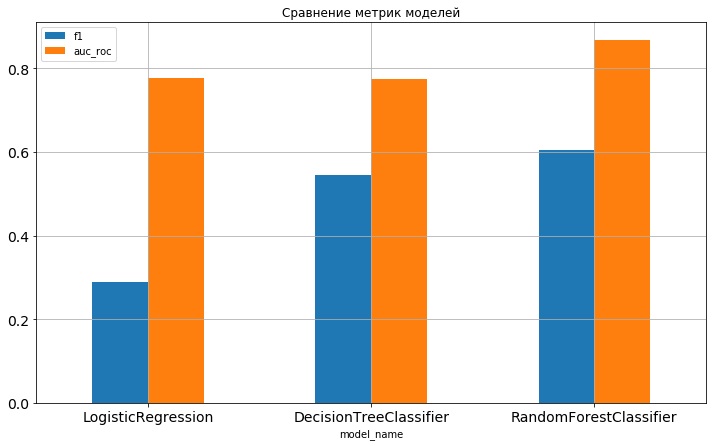

In [20]:
model_score.plot(x='model_name', kind='bar', figsize=(12,7), fontsize=14, grid=True,
                 title='Сравнение метрик моделей' )
plt.xticks(rotation=0)

Дисбаланс сильно сказывается на качестве моделей, больше всего от дисбаланса страдает модель логической регрессии

# 3. Борьба с дисбалансом

Сначала попробуем убрать дисбаланс с помощью аргумента class_weight

In [21]:
balanced_model_score = pd.DataFrame(columns=['model_name', 'f1', 'auc_roc'])

In [22]:
best_c = 0
best_auc_roc = 0
best_f1 = 0

for c in np.arange(0.03, 0.05, 0.001):
    model = LogisticRegression(random_state=SEED, C=c, solver='liblinear',
                               class_weight='balanced')
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted)
    if f1 > best_f1:
        best_f1 = f1
        best_c = c
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one)
print('best C:', best_c)        
balanced_model_score = print_and_add(balanced_model_score, 'LogisticRegression',
                                     best_f1, best_auc_roc)

best C: 0.032
best F1: 0.513
best AUC-ROC: 0.783


In [23]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
for depth in trange(8,15):    
    model = DecisionTreeClassifier(random_state=SEED, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted) 
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', depth)

balanced_model_score = print_and_add(balanced_model_score, 'DecisionTreeClassifier',
                                     best_f1, best_auc_roc)


best depth: 14
best F1: 0.577
best AUC-ROC: 0.744


In [24]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
best_est = 0

for est in trange(155, 160):    
    for depth in range(5,13):    
        model = RandomForestClassifier(random_state=SEED, max_depth=depth, n_estimators=est,
                                       class_weight='balanced')
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted) 
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
            probabilities = model.predict_proba(features_valid)
            probabilities_one = probabilities[:,1]
            best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', best_depth)
print('best n_estimators:', est)
balanced_model_score = print_and_add(balanced_model_score, 'RandomForestClassifier',
                                     best_f1, best_auc_roc)


best depth: 9
best n_estimators: 159
best F1: 0.647
best AUC-ROC: 0.870


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

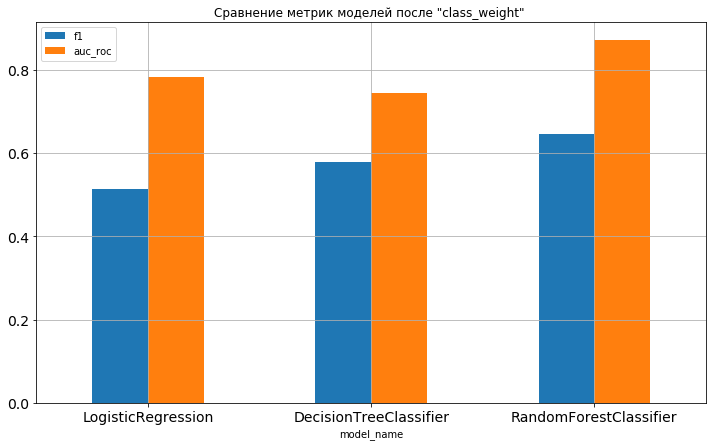

In [25]:
balanced_model_score.plot(x='model_name', kind='bar', figsize=(12,7), fontsize=14, grid=True,
                          title='Сравнение метрик моделей после "class_weight" ' )
plt.xticks(rotation=0)

Попробуем увеличить у 4 раза объекты редкого класса

In [26]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled,
                                                   random_state=SEED)
    return features_upsampled, target_upsampled

In [27]:
features_train, target_train = upsample(features_train, target_train, 4)
target_train.value_counts(normalize=True)

1   0.51
0   0.49
Name: exited, dtype: float64

После копирования классы практически равны

In [28]:
upsample_model_score = pd.DataFrame(columns=['model_name', 'f1', 'auc_roc'])

In [29]:
best_c = 0
best_auc_roc = 0
best_f1 = 0

for c in np.arange(0.03, 0.05, 0.001):
    model = LogisticRegression(random_state=SEED, C=c, solver='liblinear')
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted)
    if f1 > best_f1:
        best_f1 = f1
        best_c = c
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one)
print('best C:', best_c)        
upsample_model_score = print_and_add(upsample_model_score, 'LogisticRegression',
                                     best_f1, best_auc_roc)

best C: 0.034
best F1: 0.505
best AUC-ROC: 0.783


In [30]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
for depth in trange(8,15):    
    model = DecisionTreeClassifier(random_state=SEED, max_depth=depth)
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted) 
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', depth)

upsample_model_score = print_and_add(upsample_model_score, 'DecisionTreeClassifier',
                                     best_f1, best_auc_roc)


best depth: 14
best F1: 0.587
best AUC-ROC: 0.766


In [31]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
best_est = 0

for est in trange(155, 160):    
    for depth in range(5,13):    
        model = RandomForestClassifier(random_state=SEED, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted) 
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
            probabilities = model.predict_proba(features_valid)
            probabilities_one = probabilities[:,1]
            best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', best_depth)
print('best n_estimators:', est)
upsample_model_score = print_and_add(upsample_model_score, 'RandomForestClassifier',
                                     best_f1, best_auc_roc)


best depth: 11
best n_estimators: 159
best F1: 0.655
best AUC-ROC: 0.871


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

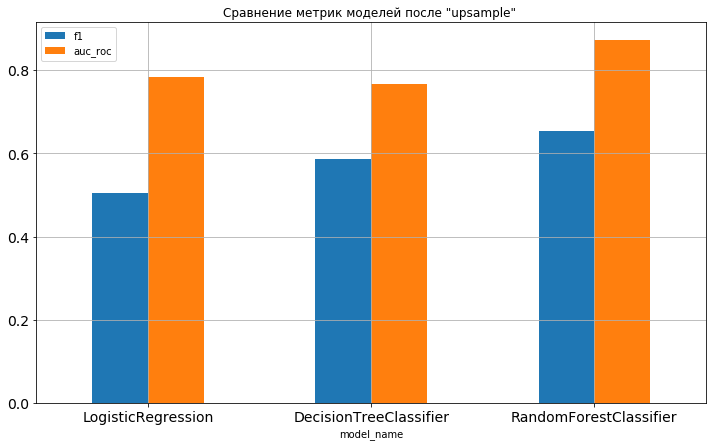

In [32]:
upsample_model_score.plot(x='model_name', kind='bar', figsize=(12,7), fontsize=14, grid=True,
                          title='Сравнение метрик моделей после "upsample" ' )
plt.xticks(rotation=0)

In [33]:
model_score # Не сбалансированная выборка

,model_name,f1,auc_roc
0,LogisticRegression,0.29,0.78
1,DecisionTreeClassifier,0.54,0.77
2,RandomForestClassifier,0.60,0.87


In [34]:
balanced_model_score # Балансировка "class_weight"

,model_name,f1,auc_roc
0,LogisticRegression,0.51,0.78
1,DecisionTreeClassifier,0.58,0.74
2,RandomForestClassifier,0.65,0.87


In [35]:
upsample_model_score # Балансировка "upsample"

,model_name,f1,auc_roc
0,LogisticRegression,0.51,0.78
1,DecisionTreeClassifier,0.59,0.77
2,RandomForestClassifier,0.65,0.87


Мы видим существенное отличие моделей, на не сбалансированной выборке, и моделей на сбалансированной выборке.<br> Между способами балансировки, различия заметны только в алгоритме "Дерево решений".<br>
Хуже всего с поставленной задачей справился алгоритм "Логической регрессии", и отсутствие баланса в выборке на его качестве сказывается сильнее всего.<br> Лидером является алгоритм "Случайный лес", он же меньше остальных страдает от дисбаланса.

# 4. Тестирование модели

Предобработаем тестовые данные

In [36]:
test = pd.get_dummies(test, drop_first=True)

Перекодировали категориальные признаки с помощью OHE

In [37]:
target_test = test['exited']
features_test = test.drop(['exited'], axis=1)

In [38]:
numeric_column = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 
                 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features[numeric_column])

features[numeric_column] = scaler.transform(features[numeric_column])
features_test[numeric_column] = scaler.transform(features_test[numeric_column])

Масштабировали численные признаки

In [39]:
model = RandomForestClassifier(random_state=SEED, max_depth=9, n_estimators=159,
                               class_weight='balanced')
model.fit(features, target)
predicted = model.predict(features_test)

Обучили алгоритм "Случайный лес" на лучших гиперпараметрах полученных на валидации. С дисбалансом боролись с помощью аргумента class_weight.

F1: 0.617
AUC_ROC: 0.865
Accuracu: 0.829


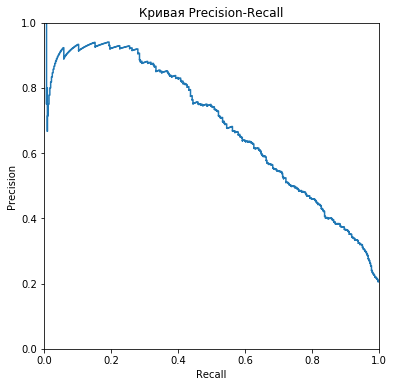

In [40]:
print('F1: {:,.3f}'.format(f1_score(target_test, predicted)))
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:,1]
print('AUC_ROC: {:,.3f}'.format(roc_auc_score(target_test, probabilities_one)))
print('Accuracu: {:,.3f}'.format(model.score(features_test, target_test)))
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_one)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

Accuracu нашей модели практически 83%. Значение метрики AUC_ROC 0.87, наша модель проходит тест н адекватность и умеет предсказывать уход клиента лучше, чем случайная модель. <br>
Так как в условии задачи говориться что маркетологи провели расчеты и сравнили стоимость привлечения нового клиента и удержание текущего, рекомендую взять у них эти данные и учесть в определение порога.